## PPI General Linear Model

Here, PPI network construction is performed by evaluating multiple linear models and extracting regressors beta weights. PPI linear model takes form: 

$$y=\beta_0+\beta_1\cdot x_{physio}+\beta_2\cdot x_{perr\_ons}+\beta_3\cdot x_{perr\_full}+
            \beta_4\cdot x_{PPI:perr\_ons}+\beta_5\cdot x_{PPI:perr\_full}+
            \beta_6\cdot x_{dec\_ons}+\beta_7\cdot x_{res\_lbp}+\beta_8\cdot x_{res\_rbp}+\beta_9\cdot x_{res\_miss} 
$$

Detailed regressors description:

| Regressor | Type | Description | Event Duration
|:--:|----|----|----|
| `y` | physiological | BOLD signal from target region | – |
| | | | |
| `intercept` | other | intercept for linear model | – |
| `physio` | physiological | BOLD signal from seed region | – |
| `perr_ons` | psychological | outcome phase onset | 1s |
| `perr_full` | psychological | outcome phase onset parametrically modulated with prediction error | 1s |
| `ppi_perr_ons` | interaction | `perr_ons` point-by-point multiplied with <br />deconvolved seed timeseries, reconvolved with HRF | 1s 
| `ppi_perr_full` | interaction | `perr_full` point-by-point multiplied with <br />deconvolved seed timeseries, reconvolved with HRF | 1s |
| `dec_ons` | psychological | decision phase onset | 0s |
| `res_lbp` | psychological | left button press onset | 0s |
| `res_rbp` | psychological | right button press onset | 0s |
| `res_miss` | psychological | onset of isi phase for trials with missing response | 0s |

Each type of regressor was calculated differently: 
- **physiological regressors**: BOLD signals extracted using `NiftiSpheresMasker`. During extraction confounds (24 head motion parameters) and low-frequency drift were removed and signal was high pass-filtered (128s), 
- **psychological regressors**: task events convolved with canonical HRF using `compute_regressor` function from `nistats.hemodynamic_models` wrapped in custom `Regressor` class for consistent treating standard and parametrically modulated regressor, 
- **interaction (PPI) regressors**: first, ROIs timeseries were extracted with detrending and high-pass filtering. Then they were deconvolved using spm fuction for parameter estimation Bayes `spm_PEB.m`. Deconvolved and upsampled (by default 16 times) ROI timeseries were point-by-point multiplied with upsampled and demeaned task events timeseries to create interaction regressor in neural space. Finally, these interaction regressors were reconvolved with HRF and downsampled to create PPI regressors in BOLD space.

---
**Last update**: 08.05.2020

In [1]:
%matplotlib inline
from IPython.display import clear_output
import matplotlib.pyplot as plt
import statsmodels.regression.linear_model as sm
import pandas as pd
import numpy as np
import os

from bids import BIDSLayout
from scipy import io
from scipy.stats import zscore

path_root = os.environ.get('DECIDENET_PATH')
path_code = os.path.join(path_root, 'code')
if path_code not in sys.path:
    sys.path.append(path_code)
from dn_utils.behavioral_models import load_behavioral_data
from dn_utils.glm_utils import convolve, Regressor

In [2]:
# Directory for PPI analysis
path_out = os.path.join(path_root, 'data/main_fmri_study/derivatives/ppi')
path_networks = os.path.join(path_out, 'networks')
path_timeries = os.path.join(path_out, 'timeseries')

# Load behavioral data
path_beh = os.path.join(path_root, 'data/main_fmri_study/sourcedata/behavioral')
beh, meta = load_behavioral_data(path=path_beh, verbose=True)
n_subjects, n_conditions, n_trials, _ = beh.shape
n_volumes = 730
n_roi = 300
t_r = 2

# Load trial modulations
path_modulations = os.path.join(path_root, 'data/main_fmri_study/derivatives/nistats/modulations')
modulations_perr = np.load(os.path.join(path_modulations, 'modulations_perr.npy'))

# Load neural & BOLD timeseries
data = io.loadmat(os.path.join(path_timeries, 'time_series_neural_hmp_csf_wm_all.mat'))
time_series_neural_all = data['time_series_neural_all']
time_series_clean_all = np.load(os.path.join(path_timeries, 'time_series_hmp_csf_wm_all.npy'))
downsamples = data['k'].flatten()

Shape of beh array: (32, 2, 110, 23)
Conditions [(0, 'rew'), (1, 'pun')]
Columns: [(0, 'block'), (1, 'block_bci'), (2, 'side'), (3, 'side_bci'), (4, 'magn_left'), (5, 'magn_right'), (6, 'response'), (7, 'rt'), (8, 'won_bool'), (9, 'won_magn'), (10, 'acc_after_trial'), (11, 'onset_iti'), (12, 'onset_iti_plan'), (13, 'onset_iti_glob'), (14, 'onset_dec'), (15, 'onset_dec_plan'), (16, 'onset_dec_glob'), (17, 'onset_isi'), (18, 'onset_isi_plan'), (19, 'onset_isi_glob'), (20, 'onset_out'), (21, 'onset_out_plan'), (22, 'onset_out_glob')]


#### Create design matrix

In [3]:
def upsampled_events(onsets, n_volumes, duration, t_r, modulation=None, sampling_rate=1/16):
    '''Create upsampled regressors from given events.
    
    This function is used to create upsampled psychological regressors. These can be used to create
    interaction regressors in PPI analysis. Since deconvolved neural signal is usually upsampled 
    (sixteen times by default is SPM) and interaction regressors have to be created in the neural 
    domain, psychological regressor has to be upsampled to match sample rate for the neural 
    regressor. Then PPI regressor can be calculated as point-by-point multiplication of 
    psychological and physiological regressors.
    
    Args:
        onsets (iterable):
            Contains all event onset (in seconds).
        n_volumes (int):
            Number of scans for entire task.
        duration (float):
            Duration of event. Here, we assume all events have same duration.
        t_r (float):
            Scanning repetition time (TR).
        modulation (iterable, optional):
            Events amplitude modulation.
        sampling_rate (float):
            Upsampling rate. For 16-fold upsampling sampling_rate is 1/16.
            
    Returns:
        Numpy 1D array of length n_volumes / sampling_rate. Note that this function returns 
        demeaned psychological regressor (omitting demeaning can produce spurious PPI effects if
        deconvolution is imperfect).
    '''
    if modulation is None:
        modulation = np.ones((len(onsets), ))
    
    n_frames_per_event = int(duration / (t_r * sampling_rate))
    frame_times_up = np.arange(0, n_volumes*t_r, t_r*sampling_rate)
    ts_event_up = np.zeros(frame_times_up.shape)

    for event, amplitude in zip(onsets, modulation):
        first_frame = np.argmax(frame_times_up >= event)
        ts_event_up[range(first_frame, first_frame + n_frames_per_event)] = amplitude
        
    return ts_event_up - ts_event_up.mean()

In [4]:
frame_times = np.arange(n_volumes) * t_r
sampling_rate = 1/16
event_duration = 1
n_regressors = 10

for sub, sub_name in enumerate(meta['dim1'][21:]):
    for con, con_name in enumerate(meta['dim2']):
        
        corr_mats = np.zeros((n_roi, n_roi, n_regressors))

        # Extract task events
        resp_type = beh[sub, con, :, meta['dim4'].index('response')]
        onset_out = beh[sub, con, :, meta['dim4'].index('onset_out')]
        onset_dec = beh[sub, con, :, meta['dim4'].index('onset_dec')] 
        onset_res = beh[sub, con, :, meta['dim4'].index('onset_dec')] + \
                    beh[sub, con, :, meta['dim4'].index('rt')]

        for idx_seed in range(n_roi):

            # Physiological regressor (seed time-series)
            reg_physio = pd.DataFrame(time_series_clean_all[sub, con, :, idx_seed],
                                      columns=['physio'], index=frame_times)

            # Psychological regressors 
            reg_perr_full = Regressor(name='perr_full', frame_times=frame_times,
                                      duration=np.ones(n_trials) * event_duration, 
                                      onset=onset_out,
                                      modulation=modulations_perr[sub, con]).dm_column
            reg_perr_onset = Regressor(name='perr_ons', frame_times=frame_times,
                                       duration=np.ones(n_trials) * event_duration, 
                                       onset=onset_out).dm_column

            # PPI regressors
            ts_neural_up = time_series_neural_all[sub, con, :, idx_seed]

            ts_perr_full_up = upsampled_events(onset_out, n_volumes=n_volumes, duration=event_duration, 
                                               t_r=t_r, modulation=modulations_perr[sub, con])
            ts_perr_onset_up = upsampled_events(onset_out, n_volumes=n_volumes, duration=event_duration, 
                                                t_r=t_r)
            ts_ppi_perr_full_up = ts_neural_up * ts_perr_full_up
            ts_ppi_perr_onset_up = ts_neural_up * ts_perr_onset_up

            reg_ppi_perr_full = pd.DataFrame(
                convolve(ts_ppi_perr_full_up, t_r=t_r*sampling_rate)[downsamples],
                columns=['ppi_perr_full'],
                index=frame_times)
            reg_ppi_perr_onset = pd.DataFrame(
                convolve(ts_ppi_perr_onset_up, t_r=t_r*sampling_rate)[downsamples],
                columns=['ppi_perr_ons'], 
                index=frame_times)

            # No-interest regressors
            reg_dec_ons = Regressor('dec_ons', frame_times, onset_dec[resp_type != 0]).dm_column
            reg_res_lbp = Regressor('res_lbp', frame_times, onset_res[resp_type==-1]).dm_column
            reg_res_rbp = Regressor('res_rbp', frame_times, onset_res[resp_type==1]).dm_column
            reg_res_miss = Regressor('res_miss', frame_times, onset_dec[resp_type==0] + 2).dm_column
                
            # Create design matrix
            regressors = [reg_physio, reg_perr_onset, reg_perr_full, 
                          reg_ppi_perr_onset, reg_ppi_perr_full,
                          reg_dec_ons, reg_res_lbp, reg_res_rbp]
            
            X = pd.concat([r for r in regressors], axis=1, sort=False)
            
            # Standardize
            Xstd = (X - X.mean()) / X.std()

            # Add miss regressor and intercept
            Xstd['reg_res_miss'] = np.zeros(n_volumes) if reg_res_miss.shape[1] == 0 else \
                                  (reg_res_miss - reg_res_miss.mean()) / reg_res_miss.std()
            Xstd['reg_itercept'] = np.ones(n_volumes)
                
            clear_output()
            print(f'Analyzing: {sub_name} / {con_name} / seed: {idx_seed}')
            
            for idx_target in range(n_roi):        
                # Modeled response (target time-series)
                y = pd.DataFrame(time_series_clean_all[sub, con, :, idx_target],
                                 columns=['target'], index=frame_times)

                # Fit GLM
                model = sm.OLS(y, Xstd, hasconst=True)
                results = model.fit()

                corr_mats[idx_target, idx_seed] = results.params
                
        fname = os.path.join(
            path_networks, 
            f'sub-{sub_name}_task-{con_name}_betamats.npy')
        np.save(fname, corr_mats)

Analyzing: m33 / pun / seed: 299


### Display PPI model regressors
- Plot 1 shows individual regressor timeseries colored by regressor type
- Plot 2 shows correlation between individual regressors

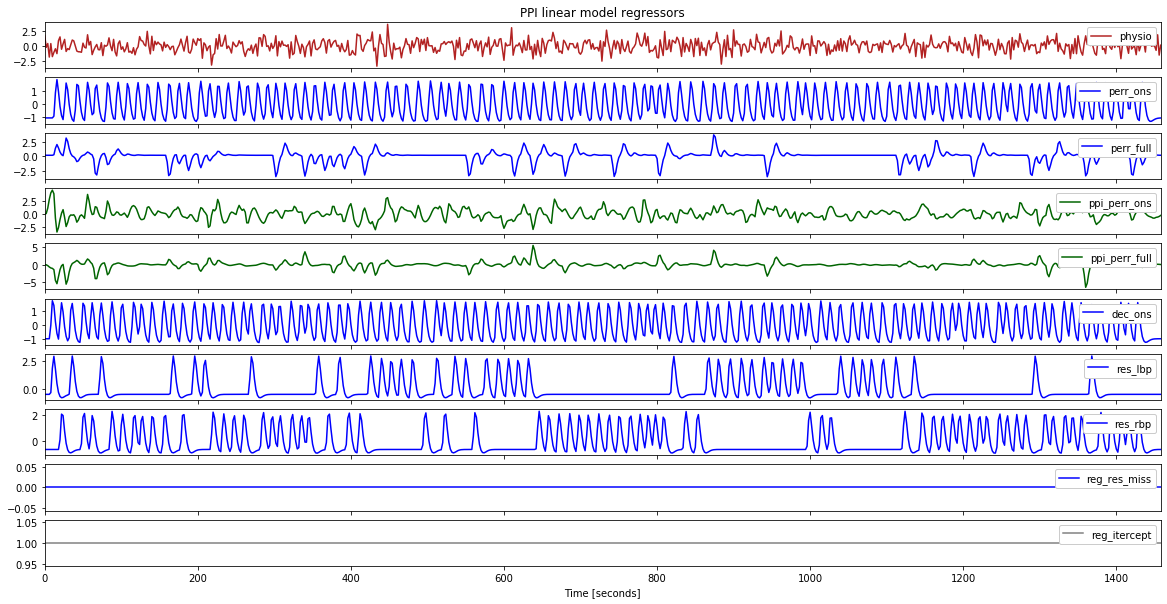

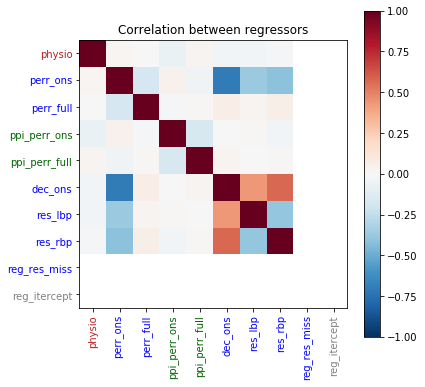

In [5]:
reg_types = ['physio', 'psycho', 'psycho', 'ppi', 'ppi', 
             'psycho', 'psycho', 'psycho', 'psycho', 'other']
reg_colors = {'physio': 'firebrick', 'psycho': 'blue',
              'ppi': 'darkgreen', 'other': 'gray'}

# Plot 1: Example regressors
fig, axs = plt.subplots(nrows=Xstd.shape[1], sharex=True, figsize=(20, 10), facecolor='w')
for i, (column, reg_type) in enumerate(zip(Xstd, reg_types)):
    axs[i].plot(frame_times, Xstd[column], color=reg_colors[reg_type], label=column)
    axs[i].legend(loc='upper right', framealpha=1)
    axs[i].set_xlim([0, max(frame_times)])
    
axs[0].set_title('PPI linear model regressors')
axs[-1].set_xlabel('Time [seconds]')

# Plot 2: Correlation between regressors
fig, ax = plt.subplots(figsize=(6, 6), facecolor='w')
plt.imshow(Xstd.corr(), cmap='RdBu_r', clim=[-1, 1])

plt.colorbar()
plt.yticks(range(Xstd.shape[1]), Xstd.columns, color=['red']*10)
plt.xticks(range(Xstd.shape[1]), Xstd.columns, rotation=90)
plt.title('Correlation between regressors')

tickcolors = (reg_colors[reg_type] for reg_type in reg_types)
for xticklabel, yticklabel, tickcolor in zip(plt.gca().get_xticklabels(), 
                                             plt.gca().get_yticklabels(), 
                                             tickcolors):
    xticklabel.set_color(tickcolor)
    yticklabel.set_color(tickcolor)

plt.show()

(-9.950000000000001, 208.95, -0.05, 1.05)

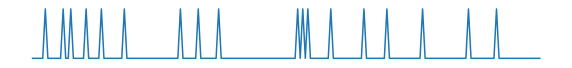

In [50]:
time_series_raw_all = np.load(os.path.join(path_timeries, 'time_series_raw_all.npy'))

from scipy.signal import butter, sosfilt

sig = np.random.random(200)
sig = (x - np.mean(x)) / np.std(x)

sos = butter(10, 30, btype='lowpass', fs=1000, output='sos')
lff = sosfilt(sos, sig)

fig, ax = plt.subplots(figsize=(10, 1))
# plt.plot(time_series_raw_all[0, 0, 1:200, 1].flatten())
# plt.plot(lff)
plt.plot(sig>1.3)

fig.patch.set_visible(False)
ax.axis('off')